# Credit Card Transaction Fraud Detection

In [1]:
# Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Oversampling and Undersampling
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Figures
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# For reproducability
RANDOM_STATE = 1

Loading the data.

In [2]:
data = pd.read_csv(r"./fraudTrain.csv")

data.drop(data.columns[0], axis=1, inplace=True)

## Imbalanced Data

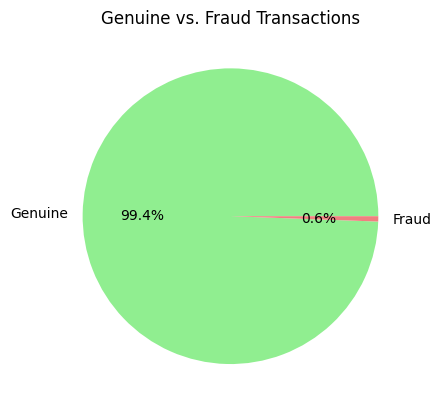

In [3]:
labels = ["Genuine", "Fraud"]

is_fraud_train = data["is_fraud"].value_counts()

plt.pie(is_fraud_train,labels=labels, colors=["lightgreen", "lightcoral"], autopct='%1.1f%%')
plt.title("Genuine vs. Fraud Transactions")
plt.show()

Since 99.4% of the data are genuine transactions, if we do a blind guess of genuine transactions, we will have an accuracy of 99.4%.

## Preprocessing Data

Renaming the columns to be more intuitive and converted the times to be datetimes.

In [4]:
data.rename(columns={"cc_num": "credit_card",
                     "trans_date_trans_time": "trans_time",
                     "trans_num": "trans_id"},
                inplace=True)

# Turning the transaction time to be numerical and based on time only.
data["trans_time"] = pd.to_datetime(data["trans_time"])
data["dob"] = pd.to_datetime(data["dob"])

data["time"] = pd.to_datetime(data["unix_time"], unit="s")
data["time"] = data["time"].dt.hour



data.head(5)

,trans_time,credit_card,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_id,unix_time,merch_lat,merch_long,is_fraud,time
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0


Next, we convert the date of birth to age and normalize the amount.

In [5]:
# Normalizing the amount via log(1 + amt)
data["amt"] = np.log1p(data["amt"])

data["age"] = data["trans_time"].dt.year - data["dob"].dt.year


Removing any unecessary features and taking the 4 most recent months as testing data to prevent data leakage.

In [6]:
# Removed trans_id. Replaced unix_time and trans_date_trans_time with time. Replaced dob with age.
# Also removed private information such as name, dob, address.
features = ['credit_card', 'merchant', 'category', 'amt', 'gender', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'age', 'merch_lat', 'merch_long', 'time']
categorical_features = ['credit_card', 'merchant', 'category', 'gender', 'state', 'zip', 'job', 'age']
target = "is_fraud"

# Separates all the data within the most recent 4 months
most_recent_transaction = data["trans_time"].max()
data["month_difference"] = abs(data["trans_time"] - most_recent_transaction) / np.timedelta64(30, "D")

MONTH_DIFF = 4
data_train = data[data.month_difference > MONTH_DIFF]
data_test = data[data.month_difference <= MONTH_DIFF]

Splitting our data into training and testing and encoding the data

In [7]:
X = data_train[features]
Y = data_train[target]

# Split the data into training and testing. Stratify the data to ensure the split is representative of the actual data.
X_train_all, X_temp_all, Y_train_all, Y_temp_all = train_test_split(X, Y, stratify=Y, train_size=0.8, random_state=RANDOM_STATE)

X_temp_all = pd.concat([X_temp_all, data_test[features]])
Y_temp_all = pd.concat([Y_temp_all, data_test[target]])

# Using ordinal encodings to encode categorical features for data.
ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, dtype=np.float64)

X_train_all.loc[:, categorical_features] = ord_enc.fit_transform(X_train_all[categorical_features])
X_temp_all.loc[:, categorical_features] = ord_enc.transform(X_temp_all[categorical_features])

X_train_all = X_train_all.astype("float64")
X_temp_all = X_temp_all.astype("float64")

X_val_all, X_test_all, Y_val_all, Y_test_all = train_test_split(X_temp_all, Y_temp_all, stratify=Y_temp_all, train_size=0.5, random_state=RANDOM_STATE)

## Feature Importance

To determine which features to select, fit a model to the data.

In [8]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
model_rf.fit(X_train_all, Y_train_all)

RandomForestClassifier(random_state=1)

Using the mean decrease in impurity (MDI), plot the feature importance to determine the most important features.

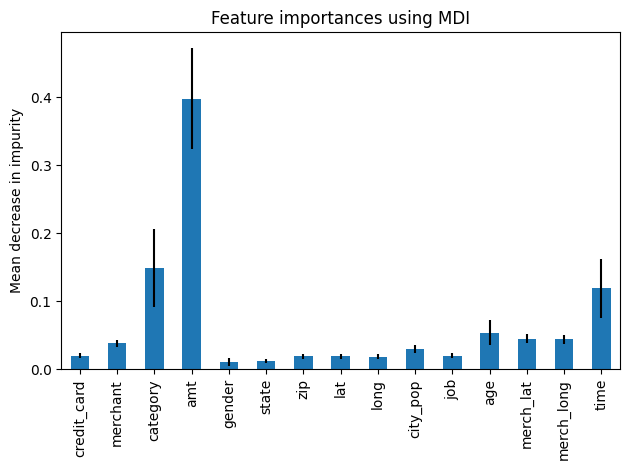

In [9]:
mdi_importances = model_rf.feature_importances_
mdi_std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

mdi_importances = pd.Series(mdi_importances, index=features)

mdi_fig, mdi_ax = plt.subplots()
mdi_importances.plot.bar(yerr=mdi_std, ax=mdi_ax)
mdi_ax.set_title("Feature importances using MDI")
mdi_ax.set_ylabel("Mean decrease in impurity")
mdi_fig.tight_layout()

Using feature permutation, plot the feature importance to determine the most important features.

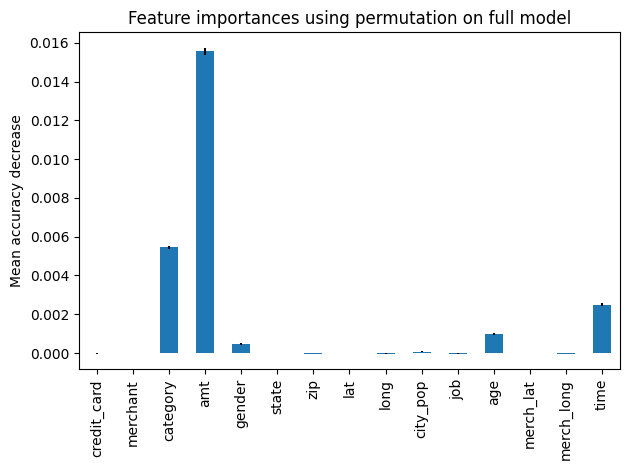

In [10]:
perm_res = permutation_importance(
    model_rf, X_val_all, Y_val_all, n_repeats=10, random_state=RANDOM_STATE, n_jobs=4
)

perm_importances = pd.Series(perm_res.importances_mean, index=features)

perm_fig, perm_ax = plt.subplots()
perm_importances.plot.bar(yerr=perm_res.importances_std, ax=perm_ax)
perm_ax.set_title("Feature importances using permutation on full model")
perm_ax.set_ylabel("Mean accuracy decrease")
perm_fig.tight_layout()
plt.show()

The features `["merchant", "category", "amt", "gender", "city_pop", "job", "age", "merch_lat", "merch_long", "time"]` were found to be the most important.

In [11]:
selected_features = ["merchant", "category", "amt", "gender", "city_pop", "age", "job", "merch_lat", "merch_long", "time"]

X_train, X_val, X_test = X_train_all[selected_features], X_val_all[selected_features], X_test_all[selected_features]
Y_train, Y_val, Y_test = Y_train_all, Y_val_all, Y_test_all

## Baseline Performance
First, we take a look at a baseline performance using Logistic Regression

In [12]:
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_val_scaled = scalar.transform(X_val)

model_logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model_logreg.fit(X_train_scaled, Y_train)

Y_pred_model_logreg = model_logreg.predict(X_val_scaled)

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    241438
           1       0.00      0.00      0.00      1428

    accuracy                           0.99    242866
   macro avg       0.50      0.50      0.50    242866
weighted avg       0.99      0.99      0.99    242866



Metrics train:
	Accuracy score: 0.9940
Metrics test:
	Accuracy score: 0.9938


Confusion Matrix:


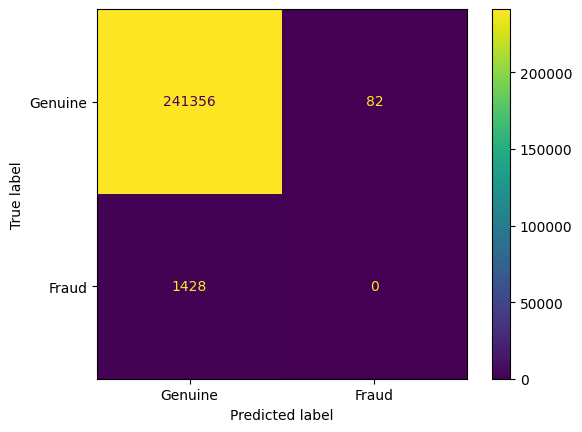

In [13]:
print(f"Classification Report: \n{classification_report(Y_val, Y_pred_model_logreg)}\n\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_logreg.predict(X_train_scaled),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_logreg.predict(X_val_scaled),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_model = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_model_logreg), display_labels=["Genuine", "Fraud"])
cm_display_model.plot()

Then, we take a look at the baseline performance of Random Forest

In [14]:
model_rf.fit(X_train, Y_train)

Y_pred_model_rf = model_rf.predict(X_val)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    241438
           1       0.97      0.77      0.86      1428

    accuracy                           1.00    242866
   macro avg       0.98      0.89      0.93    242866
weighted avg       1.00      1.00      1.00    242866



Metrics train:
	Accuracy score: 1.0000
Metrics test:
	Accuracy score: 0.9985


Confusion Matrix:


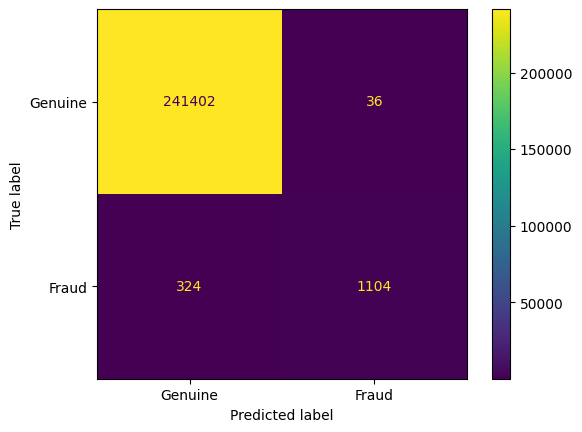

In [15]:
print(f"Classification Report: \n{classification_report(Y_val, Y_pred_model_rf)}\n\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_val),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_model = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_model_rf), display_labels=["Genuine", "Fraud"])
cm_display_model.plot()

## SMOTE + Tomek Links
Because the data is imbalanced, we combine SMOTE and Tomek Links to resample the data.

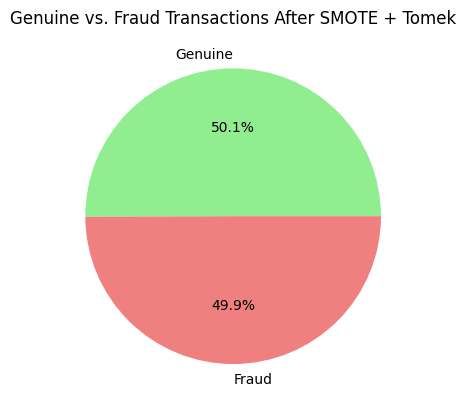

In [16]:
tomek = TomekLinks(sampling_strategy="majority")
smotetomek = SMOTETomek(tomek=tomek, random_state=RANDOM_STATE)

X_train_smotetomek, Y_train_smotetomek = smotetomek.fit_resample(X_train, Y_train)

# Plot the data after resampling
is_fraud_train_smotetomek = Y_train_smotetomek.value_counts()

plt.pie(is_fraud_train_smotetomek,labels=labels, colors=["lightgreen", "lightcoral"], autopct='%1.1f%%')
plt.title("Genuine vs. Fraud Transactions After SMOTE + Tomek")
plt.show()

Running the line of code below will cause the rest of the notebook to use the SMOTE + Tomek data.

In [17]:
X_train, Y_train = X_train_smotetomek, Y_train_smotetomek

## Model: Decision Tree
Finding and tuning hyperparameters of the Decision Tree using RandomizedSearch.

In [18]:
max_depths = [3, 5, 7, 10]  # Determines how far down a decision tree goes before stopping
min_splits = [2, 5, 10, 50] # Determines the minimum sample split size before stopping
param_grid_dt = {"max_depth": max_depths,
                            "min_samples_split": min_splits,}

grid_dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), 
                                  param_grid_dt, 
                                  verbose=3, n_jobs=4,
                                  n_iter=20, random_state=RANDOM_STATE)
grid_dt.fit(X_train, Y_train)

print(f"Decision Tree Params: {grid_dt.best_params_}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ..max_depth=3, min_samples_split=2;, score=0.825 total time=   3.5s
[CV 3/5] END ..max_depth=3, min_samples_split=2;, score=0.823 total time=   3.6s
[CV 4/5] END ..max_depth=3, min_samples_split=2;, score=0.824 total time=   3.6s
[CV 2/5] END ..max_depth=3, min_samples_split=2;, score=0.823 total time=   3.8s
[CV 5/5] END ..max_depth=3, min_samples_split=2;, score=0.824 total time=   3.4s
[CV 1/5] END ..max_depth=3, min_samples_split=5;, score=0.825 total time=   3.4s
[CV 2/5] END ..max_depth=3, min_samples_split=5;, score=0.823 total time=   3.5s
[CV 3/5] END ..max_depth=3, min_samples_split=5;, score=0.823 total time=   3.5s
[CV 4/5] END ..max_depth=3, min_samples_split=5;, score=0.824 total time=   3.4s
[CV 5/5] END ..max_depth=3, min_samples_split=5;, score=0.824 total time=   3.4s
[CV 1/5] END .max_depth=3, min_samples_split=10;, score=0.825 total time=   3.4s
[CV 2/5] END .max_depth=3, min_samples_split=10;

```{note}
This may take a while, so not running RandomizedSearch and using the default values given should work.
```

Fitting the data to the Decision Tree with the hyperparameters found.

In [19]:
try:
    max_depth_dt = grid_dt.best_params_["max_depth"]
    min_samples_split_dt = grid_dt.best_params_["min_samples_split"]
except (NameError, AttributeError):
    max_depth_dt = 10
    min_samples_split_dt = 50

model_dt = DecisionTreeClassifier(
                            min_samples_split=min_samples_split_dt,
                            max_depth=max_depth_dt,
                            random_state=RANDOM_STATE)
model_dt.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=1)

Analysis using a classification report, confusion matrix and accuracy.

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    241438
           1       0.19      0.85      0.32      1428

    accuracy                           0.98    242866
   macro avg       0.60      0.91      0.65    242866
weighted avg       0.99      0.98      0.99    242866


Metrics train:
	Accuracy score: 0.9445
Metrics test:
	Accuracy score: 0.9784


Confusion Matrix:


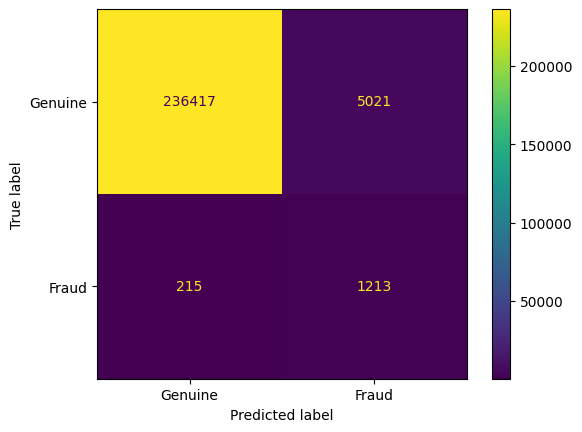

In [20]:
Y_pred_dt = model_dt.predict(X_val)

print(f"Classification Report: \n{classification_report(Y_val, Y_pred_dt)}\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_dt.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_dt.predict(X_val),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_dt = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_dt), display_labels=["Genuine", "Fraud"])
cm_display_dt.plot()

## Model: Random Forest
Becasue Decision Trees are sensitive to changes in data, we use the tree ensemble method Random Forest to mitigate the effects of changes in data.

Finding and tuning hyperparameters of the Random Forest using RandomizedSearch.

In [22]:
max_depths = [3, 5, 7, 10] # Determines how far down a decision tree goes before stopping
min_splits = [2, 5, 10, 50] # Determines the minimum sample split size before 
n_estimators = [50, 100, 150, 200] # Determines the number of trees used per forest
param_grid_rf = {"max_depth": max_depths,
                            "min_samples_split": min_splits,
                            "n_estimators": n_estimators}

grid_rf = RandomizedSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), 
                                  param_grid_rf, 
                                  verbose=3, n_jobs=4,
                                  n_iter=10, random_state=RANDOM_STATE)
grid_rf.fit(X_train, Y_train)

print(f"Random Forest Params: {grid_rf.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END max_depth=7, min_samples_split=50, n_estimators=50;, score=0.912 total time= 1.5min
[CV 4/5] END max_depth=7, min_samples_split=50, n_estimators=50;, score=0.913 total time= 1.5min
[CV 2/5] END max_depth=7, min_samples_split=50, n_estimators=50;, score=0.908 total time= 1.5min
[CV 1/5] END max_depth=7, min_samples_split=50, n_estimators=50;, score=0.911 total time= 1.5min
[CV 5/5] END max_depth=7, min_samples_split=50, n_estimators=50;, score=0.912 total time= 1.4min
[CV 3/5] END max_depth=7, min_samples_split=10, n_estimators=100;, score=0.914 total time= 2.8min
[CV 1/5] END max_depth=7, min_samples_split=10, n_estimators=100;, score=0.916 total time= 2.8min
[CV 2/5] END max_depth=7, min_samples_split=10, n_estimators=100;, score=0.914 total time= 2.9min
[CV 1/5] END max_depth=5, min_samples_split=5, n_estimators=50;, score=0.876 total time= 1.1min
[CV 2/5] END max_depth=5, min_samples_split=5, n_estimators=50;,

```{note}
This will take a while, so not running RandomizedSearch and using the default values given should work.
With the default hyperparameters, it should take 4-12 minutes.
```

Fitting the data to the Random Forest with the hyperparameters found.

In [23]:
try:
    max_depth_rf = grid_rf.best_params_["max_depth"]
    min_samples_split_rf = grid_rf.best_params_["min_samples_split"]
    n_estimators_rf = grid_rf.best_params_["n_estimators"]
except (NameError, AttributeError):
    max_depth_rf = 10
    min_samples_split_rf = 2
    n_estimators_rf = 150

model_rf = RandomForestClassifier(
                            min_samples_split=min_samples_split_rf,
                            max_depth=max_depth_rf,
                            n_estimators=n_estimators_rf,
                            random_state=RANDOM_STATE)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, min_samples_split=50, random_state=1)

Analysis using a classification report, confusion matrix and accuracy.

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    241438
           1       0.22      0.86      0.35      1428

    accuracy                           0.98    242866
   macro avg       0.61      0.92      0.67    242866
weighted avg       0.99      0.98      0.99    242866


Metrics train:
	Accuracy score: 0.9361
Metrics test:
	Accuracy score: 0.9815


Confusion Matrix:


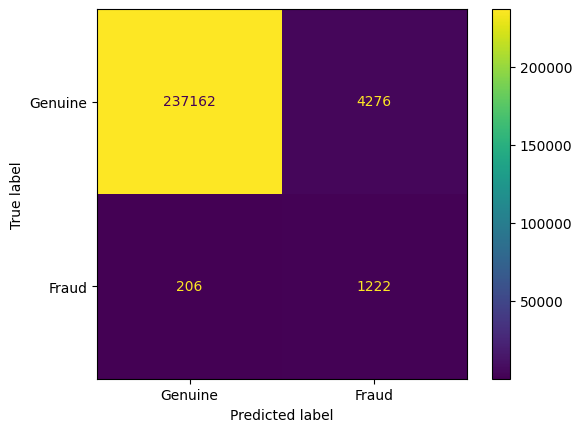

In [24]:
Y_pred_rf = model_rf.predict(X_val)

print(f"Classification Report: \n{classification_report(Y_val, Y_pred_rf)}\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_val),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_rf), display_labels=["Genuine", "Fraud"])
cm_display_rf.plot()

### Model: XGBoostClassifier
In order to speedup the algorithm, we use XGBoost.

Finding and tuning hyperparameters of the XGBClassifier using RandomizedSearch.

In [25]:
max_depths = [3, 5, 7, 10] # Determines how far down a decision tree goes before stopping
gamma = [0.1, 0.3, 0.5, 0.9] # Determines minimum loss reduction for a split
min_child_weight = [1, 3, 5, 7] #  Determines minimum weight needed for a child
param_grid_xgb = {"max_depth": max_depths,
                  "gamma": gamma,
                  "min_child_weight": min_child_weight}

grid_xgb = RandomizedSearchCV(XGBClassifier(random_state=RANDOM_STATE), 
                                  param_grid_xgb, 
                                  verbose=3, n_jobs=4,
                                  n_iter=15, random_state=RANDOM_STATE)
grid_xgb.fit(X_train, Y_train)

print(f"Random Forest Params: {grid_xgb.best_params_}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END gamma=0.3, max_depth=7, min_child_weight=1;, score=0.996 total time=   4.7s
[CV 3/5] END gamma=0.3, max_depth=7, min_child_weight=1;, score=0.998 total time=   4.8s
[CV 2/5] END gamma=0.3, max_depth=7, min_child_weight=1;, score=0.998 total time=   4.8s
[CV 4/5] END gamma=0.3, max_depth=7, min_child_weight=1;, score=0.998 total time=   4.9s
[CV 1/5] END gamma=0.5, max_depth=5, min_child_weight=7;, score=0.994 total time=   3.4s
[CV 2/5] END gamma=0.5, max_depth=5, min_child_weight=7;, score=0.996 total time=   3.5s
[CV 3/5] END gamma=0.5, max_depth=5, min_child_weight=7;, score=0.996 total time=   3.5s
[CV 5/5] END gamma=0.3, max_depth=7, min_child_weight=1;, score=0.998 total time=   4.3s
[CV 4/5] END gamma=0.5, max_depth=5, min_child_weight=7;, score=0.996 total time=   3.4s
[CV 1/5] END gamma=0.9, max_depth=5, min_child_weight=1;, score=0.994 total time=   3.5s
[CV 5/5] END gamma=0.5, max_depth=5, min_child_we

```{note}
This may take a while, so not running RandomizedSearch and using the default values given should work.
```

Fitting the data to the XGBClassifier with the hyperparameters found.

In [26]:
try:
    max_depth_xgb = grid_xgb.best_params_["max_depth"]
    gamma_xgb = grid_xgb.best_params_["gamma"]
    min_child_weight_xgb = grid_xgb.best_params_["min_child_weight"]
except (NameError, AttributeError):
    max_depth_xgb = 7
    gamma_xgb = 0.1
    min_child_weight_xgb = 5

model_xgb = XGBClassifier(
                            max_depth=max_depth_xgb,
                            gamma=gamma_xgb,
                            min_child_weight=min_child_weight_xgb,
                            random_state=RANDOM_STATE)

model_xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    241438
           1       0.89      0.82      0.85      1428

    accuracy                           1.00    242866
   macro avg       0.94      0.91      0.93    242866
weighted avg       1.00      1.00      1.00    242866


Metrics train:
	Accuracy score: 0.9996
Metrics test:
	Accuracy score: 0.9983


Confusion Matrix:


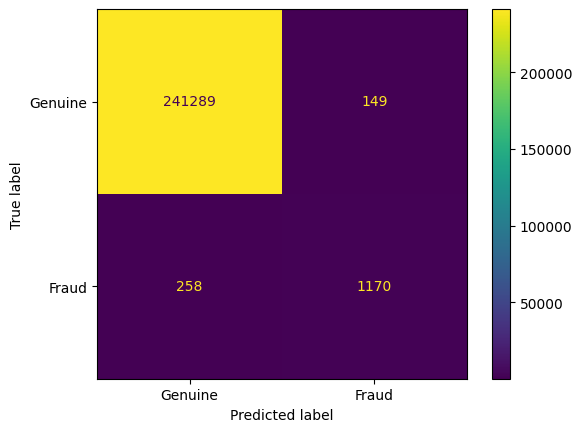

In [27]:
Y_pred_xgb = model_xgb.predict(X_val)

print(f"Classification Report: \n{classification_report(Y_val, Y_pred_xgb)}\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_xgb.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_xgb.predict(X_val),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_xgb = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_xgb), display_labels=["Genuine", "Fraud"])
cm_display_xgb.plot()

## Cross Validation

We perform cross validation by comparing `f1` scores across the three models we trained.

In [28]:
models = {"Decision Tree": model_dt,
          "Random Forest": model_rf,
          "XGBoost": model_xgb}

strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

best_model = None
best_f1 = None
for name, model in models.items():
    cross_val_res = cross_val_score(model, X_train, Y_train, cv=strat_kf, scoring="f1")

    val_f1 = f1_score(Y_val, model.predict(X_val))

    print(f"{name}: Mean F1 Training = {cross_val_res.mean():.4f}")
    print(f"{name}: F1 Validation = {val_f1:.4f}")

    if best_f1 is None or best_f1 < val_f1:
        best_model = model
        best_f1 = val_f1

Decision Tree: Mean F1 Training = 0.9424
Decision Tree: F1 Validation = 0.3166
Random Forest: Mean F1 Training = 0.9325
Random Forest: F1 Validation = 0.3529
XGBoost: Mean F1 Training = 0.9988
XGBoost: F1 Validation = 0.8518


```{note}
This may take a while, so not running the cross validation and using the default best model given below should work.
```

We found the best model to be the XGBoosted trees because it has the highest `f1` score.

## Testing

Finally, we perform a final test on the best model.

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    241438
           1       0.87      0.82      0.85      1428

    accuracy                           1.00    242866
   macro avg       0.94      0.91      0.92    242866
weighted avg       1.00      1.00      1.00    242866


Metrics test:
	Accuracy score: 0.9983


Confusion Matrix:


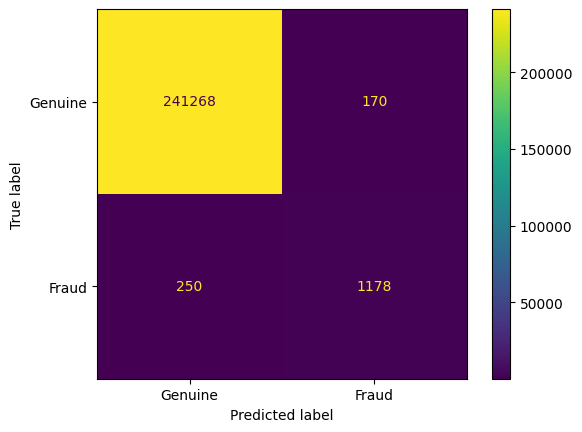

In [29]:
try:
    Y_pred_best = best_model.predict(X_test)
except NameError:
    Y_pred_best = model_xgb.predict(X_test)

print(f"Classification Report: \n{classification_report(Y_test, Y_pred_best)}\n")

print(
    f"Metrics test:\n\tAccuracy score: {accuracy_score(best_model.predict(X_test),Y_test):.4f}\n\n")

print("Confusion Matrix:")
cm_display_best = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred_best), display_labels=["Genuine", "Fraud"])
cm_display_best.plot()